### Data Augmentation

In this notebook data augmentation is performed for improving the performances of the ConvLSTM model. 

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2\models
c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2


In [2]:
import importlib
import torch
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_4batch_16hidden_3kernel_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

In [8]:
# transformed_dataset = augmentation(train_dataset, p_hflip=0.5, full=True)

In [9]:
# # Split dataset into train and validation
# train_percnt = 0.8
# train_size = int(train_percnt * len(transformed_dataset))
# val_size = len(transformed_dataset) - train_size
# train_set, val_set = random_split(transformed_dataset, [train_size, val_size])

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_wd, scaler_q, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_wd, scaler_q, train_val)

In [11]:
# Model

# Model
# model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], 
#                           hidden_dim = 8, kernel_size = (3, 3), num_layers = 2, batch_first=True, bias=True, return_all_layers = False).to(device)

model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 16, kernel_size = (3, 3),
                 num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [12]:
model

ConvLSTM(
  (conv2): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [13]:
# Set training parameters
learning_rate = 0.001
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 100 #1_000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [14]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    if epoch%100 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
    if count > 100:
        print(f"Loss Stagnated for 100 epochs, early stopping initiated")
        break

Epoch: 100 	 Training loss:  2.21e-02 	 Validation loss:  1.93e-02 	 Best validation loss:  1.82e-02


In [15]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

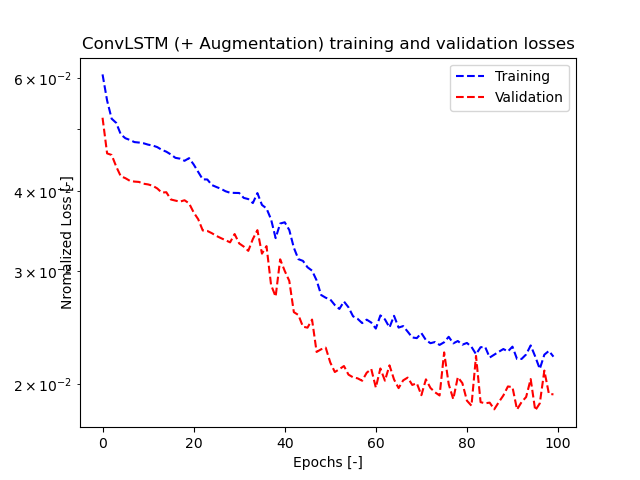

In [23]:
plot_losses(train_losses, val_losses, 'ConvLSTM (+ Augmentation) ')

In [70]:
from post_processing.cool_animation import *

In [91]:
def bello(sample, dataset, model, train_val, scaler_x,
                   scaler_wd, scaler_q, device='cuda', save=False):

    # Extracting information from the dataset
    input = dataset[sample][0]
    target = dataset[sample][1]
    boundary_condition = input[0][3]
    
    time_steps = target.shape[0]

    # Denormalizing the data for plotting
    elevation, water_depth, discharge = denormalize_dataset(
        input, target, train_val, scaler_x, scaler_wd, scaler_q)
    
    print(f'Elevation shape: {elevation.shape}, type: {type(elevation)}')
    print(f'water_depth shape: {water_depth.shape}, type: {type(water_depth)}')
    print(f'discharge shape: {discharge.shape}, type: {type(discharge)}')

    return None

In [92]:
bello(10, normalized_train_dataset, model, train_val,
               scaler_x, scaler_wd, scaler_q, device = device, save = False)

Elevation shape: (64, 64), type: <class 'numpy.ndarray'>
water_depth shape: (48, 64, 64), type: <class 'numpy.ndarray'>
discharge shape: (48, 64, 64), type: <class 'numpy.ndarray'>


In [74]:
normalized_train_dataset[0][1].shape

torch.Size([48, 2, 64, 64])

In [269]:
def plot_sorted(dataset, train_val, scaler_x, scaler_wd, scaler_q, model, device):
    '''
    Function for plotting the DEMs variation sorted in increasing order 
    of average loss (of Water Depth and Discharge)

    Input: dataset = tensor, normalized dataset
           train_val_test : str, Identifier of dictionary. Expects: 'train_val', 'test1', 'test2', 'test3'.
           scaler_x, scaler_wd, scaler_q = scalers for inputs (x) and targets (water depth and discharge), created 
                                            with the scaler function 
    Output: None (plot)
    '''
    
    # get inputs and outputs
    # 1st sample, 2nd input(0)/target(1), 3rd time step, 4th features, 5th/6th pixels
    
    n_samples = len(dataset)
    n_features = dataset[0][1].shape[1]
    n_pixels = dataset[0][1].shape[-1]
    time_steps = dataset[0][1].shape[0]

    # print(f'Samples: {n_samples}')
    # print(f'Features: {n_features}')
    # print(f'Pixels: {n_pixels}')
    # print(f'Time steps: {time_steps}\n')
    
    # initialize inputs and outputs
    inputs = []
    targets = []
    
    for i in range(n_samples):
        inputs.append(dataset[i][0])
        targets.append(dataset[i][1])

    # print(f'Inputs shape: {np.shape(inputs[0])}, targets shape: {np.shape(targets[0])}')
    # print(f'Input type: {type(inputs)}\n')

    # initialize denormalization of dataset
    elevation = np.zeros((n_samples, n_pixels, n_pixels))
    water_depth = np.zeros((n_samples, time_steps, n_pixels, n_pixels))
    discharge = np.zeros((n_samples, time_steps, n_pixels, n_pixels))

    # initialize losses
    losses = torch.zeros((n_samples, n_features))

    for i in range(n_samples):
        # denormalize dataset
        elevation[i], water_depth[i], discharge[i] = denormalize_dataset(inputs[i], targets[i], train_val, 
                                                            scaler_x, scaler_wd, scaler_q)
        # make predictions
        preds = obtain_predictions(model, inputs[i], device)
    
    # print(f'Elevation {elevation}, shape: {elevation.shape}, type: {type(elevation)}')
    # print(f'water_depth shape: {water_depth.shape}, type: {type(water_depth)}')
    # print(f'discharge shape: {discharge.shape}, type: {type(discharge)}')
    # print(f'predictions shape: {preds.shape}, type: {type(preds)}')
    # print(f'predictions wd shape: {preds[:,0].shape}, type: {type(preds[:,0])}')
    # print(f'predictions q shape: {preds[:,0].shape}, type: {type(preds[:,0])}\n')

    # compute MSE losses
    for feature in range(n_features):
            for i in range(n_samples):
                 losses[i, feature] = nn.MSELoss()(preds[:][feature], targets[i][:][feature])
    
    # print(f'losses shape: {losses.shape}, type: {type(losses)}\n')
    
    avg_loss = torch.mean(losses, dim=1) 
    # print(f'Avg loss shape: {avg_loss.shape}, type:{type(avg_loss)}\n')

    # compute recall - improvement: add minimium threshold for recall (wd > 10 cm), need to denormalize targets and predictions
    # ask scaler what 10 is and plot that scaler_wd.transform(0.10) - check
    recall, _, _ = confusion_mat(dataset, model, device)

    # print(f'recall: {recall}, shape: {recall.shape}\n')
    indexes = torch.arange(n_samples)
    sort_ind = indexes[torch.argsort(avg_loss)]

    # sorting dataset
    sorted_loss, sorted_indexes = torch.sort(avg_loss)
    # print(f'sorted_indexes: {sorted_indexes}, sorted_loss: {sorted_loss}')
    # print(f'sorted_indexes shape: {sorted_indexes.shape}, sorted_loss shape: {sorted_loss.shape}\n')

    elevation_sorted = elevation[sorted_indexes] 
    # print(f'Elevation sorted shape: {elevation_sorted.shape}, type: {type(elevation_sorted)}')
    # print(f'Check if they are the same {elevation==elevation_sorted}')
    wd_sorted, q_sorted = water_depth[sorted_indexes], discharge[sorted_indexes]     
    # print(f'wd_sorted shape: {wd_sorted.shape}, type: {type(wd_sorted)}')
    # print(f'Check if they are the same {water_depth==wd_sorted}\n')
    # print(f'wd_sorted shape: {q_sorted.shape}, type: {type(q_sorted)}')
    # print(f'Check if they are the same {discharge==q_sorted}\ng')
    sorted_recall = recall[sorted_indexes] 
    # print(f'sorted_recall shape: {sorted_recall.shape}, type: {type(sorted_recall)}')
    # print(f'Check if they are the same {recall==sorted_recall}\n')
    
    # plot 
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.subplots_adjust(wspace=1)

    # create second y-axis for discharge scale
    ax1_2 = axes[1].twinx()
    axes[0].boxplot(elevation_sorted[0])
    axes[1].scatter(sort_ind, losses[:,0], color='blue', marker='x', label='water depth')
    ax1_2.scatter(sort_ind, losses[:,1], color='red', marker='x', label='discharge')
    axes[2].scatter(sorted_indexes, sorted_recall, color='green', marker='x', label='recall')

    for ax in axes:
        ax.set_xlabel('Sample ID')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    axes[0].set_ylabel('Normalized variation [-]')
    axes[1].set_ylabel('Normalized Water Depth loss [-]')
    ax1_2.set_ylabel('Normalized Discharge loss [-]')
    axes[2].set_ylabel('Recall [-]')

    axes[0].set_title('Normalized DEM variation [-]')
    axes[1].set_title('Normalized MSE loss [-]')
    axes[2].set_title('Recall [-]')

    # plt.xticks(rotation=90)
    fig.legend()
    fig.show()
    return None

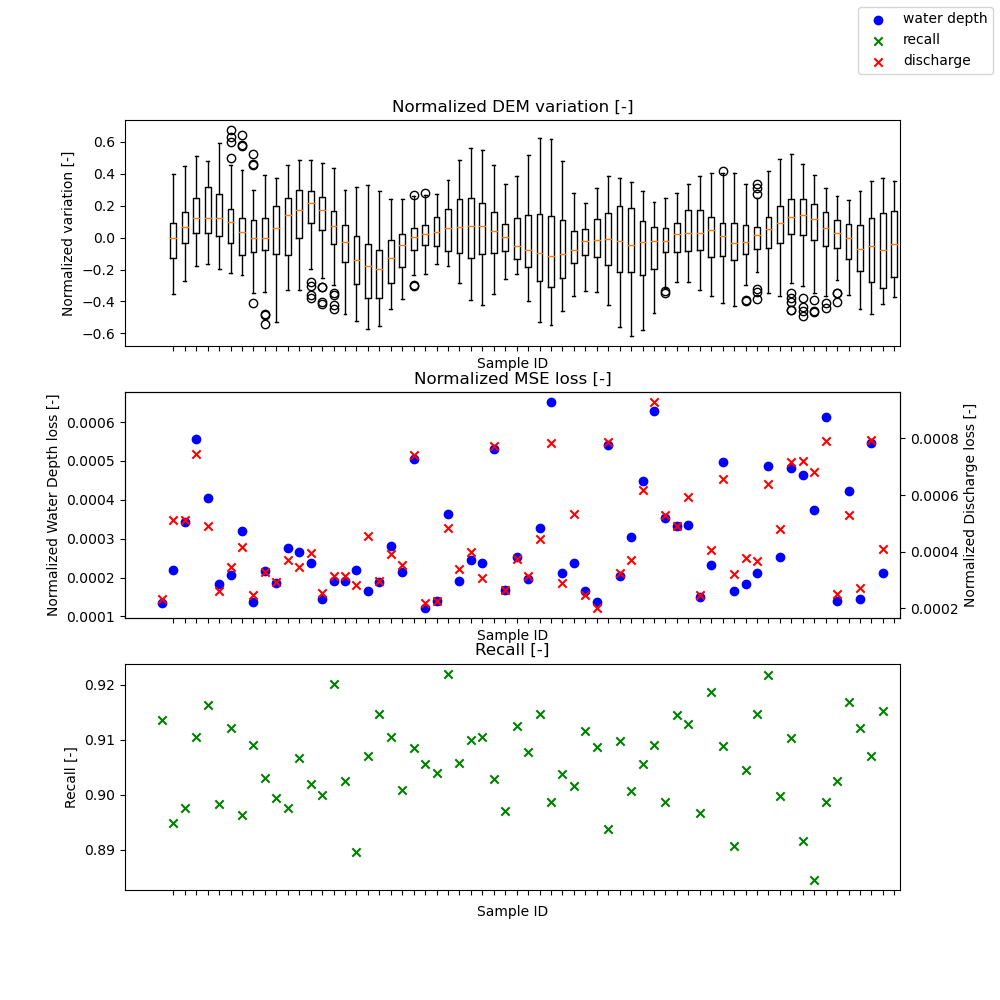

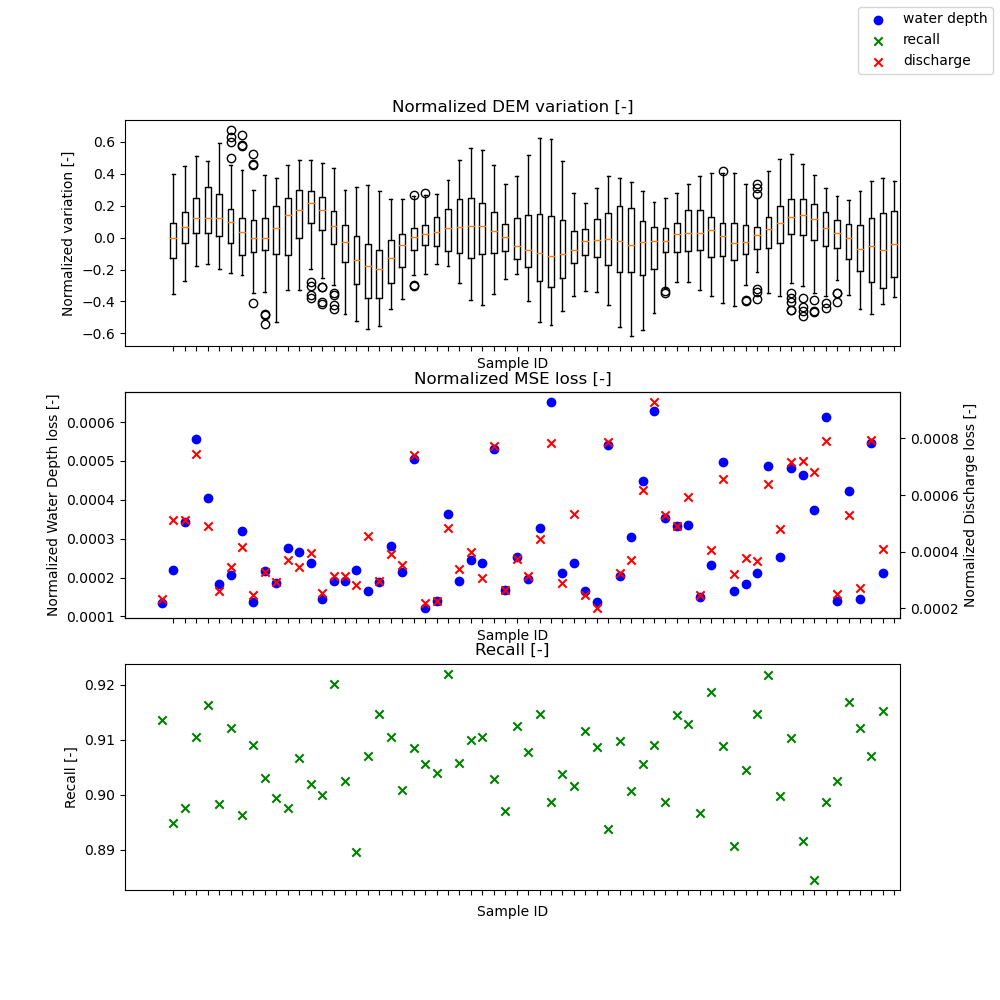

In [270]:
plot_sorted(normalized_train_dataset, train_val, scaler_x, scaler_wd, scaler_q, model, device)

In [35]:
# n_samples = len(normalized_train_dataset)
# n_features = normalized_train_dataset[0][1].shape[1]
# n_pixels = normalized_train_dataset[0][1].shape[-1]
# time_steps = normalized_train_dataset[0][1].shape[0]

# print(n_samples)
# print(n_features)
# print(n_pixels)
# print(time_steps)